# Kernel Density Estimation for outlier detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline

Read SDSS data, preprocessed by colour indices and reddenning correction

In [2]:
sdss = pd.read_hdf('../data/sdss.h5', 'sdss')
sdss.head()

,ra,dec,class,psfMag_r_w14,psf_u_g_w14,psf_g_r_w14,psf_r_i_w14,psf_i_z_w14,petroMag_r_w14,petro_u_g_w14,petro_g_r_w14,petro_r_i_w14,petro_i_z_w14,petroRad_r
0,189.429821,-0.131042,Star,-1.662200,-0.241727,-1.822259,-1.687239,-1.711647,-1.116388,-0.070626,-1.593511,-1.560112,-0.898704,-0.753122
1,189.453801,-0.097313,Star,-2.012570,-0.439270,-0.909222,-0.912979,-1.080839,-1.422942,-0.203637,-0.830489,-0.827023,-0.549991,-0.761758
2,189.468747,-0.036000,Star,-2.336939,-0.382566,-0.761093,-0.550549,-1.104779,-1.723089,-0.167706,-0.688523,-0.543300,-0.495537,-0.762067
3,196.236650,0.412347,Galaxy,1.212605,0.299037,1.139600,1.495727,0.218688,1.150914,-0.239479,1.633250,1.309430,0.391270,-0.455298
4,196.193644,0.389485,Galaxy,1.429818,-0.922955,0.136786,1.242569,1.943976,1.104454,2.777891,1.323889,1.364680,0.475582,-0.114286


Use the same features as reported in Alasdair Tran's Honours thesis 2015.

In [3]:
target_col = 'class'
sdss_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
                'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
                'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']

(**TODO**) Define the training, validation, and test sets, and select appropriate Gaussian kernel bandwidth. Use sklearn's [grid search](http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html) to find a good bandwidth.

In [4]:
h = 1/np.sqrt(0.02) # Bandwidth coming from Alasdair's SVM experiments
idx_all = np.random.permutation(len(sdss))
idx_train = idx_all[:100000]
idx_test = idx_all[:10000]

Estimate a kernel density estimator on the training set

In [5]:
kde = KernelDensity(kernel='gaussian', bandwidth=h, rtol=1e-5)
Xtrain = sdss[sdss_features].ix[idx_train] 
kde.fit(Xtrain)

KernelDensity(algorithm='auto', atol=0, bandwidth=7.0710678118654755,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=1e-05)

Use the fitted density to estimate the log density for all items in the test set

In [6]:
Xtest = sdss[sdss_features].ix[idx_test]
pred = kde.score_samples(Xtest)

Choose an appropriate threshold for identifying outliers

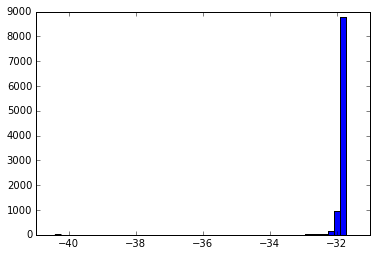

In [7]:
_ = plt.hist(pred, bins=50)

In [8]:
idx_sort = np.argsort(pred)
pred[idx_sort[:10]]

array([-40.40748064, -38.15861196, -34.90744968, -34.50653683,
       -34.28533322, -34.14706098, -34.10068879, -33.92484664,
       -33.86291526, -33.83880354])

Identify the outliers in the dataset. (**TODO**) Export or visualise appropriately for getting feedback from the astronomers.

In [9]:
idx_outlier = idx_test[np.where(pred < -34)]
sdss.ix[idx_outlier]

,ra,dec,class,psfMag_r_w14,psf_u_g_w14,psf_g_r_w14,psf_r_i_w14,psf_i_z_w14,petroMag_r_w14,petro_u_g_w14,petro_g_r_w14,petro_r_i_w14,petro_i_z_w14,petroRad_r
356100,247.016146,16.766389,Star,1.141678,0.585969,1.016390,1.801990,-11.359251,0.993846,1.221205,1.442701,1.312873,-10.264575,-0.255242
1445097,124.329345,0.243335,Star,-0.431172,0.955631,-0.530784,-0.896689,-16.669938,-0.378749,-0.947202,-0.064086,-1.534349,-1.324078,0.091169
2652364,252.508148,18.886469,Star,0.031854,-1.356903,-2.029131,-2.008913,-1.368899,0.105470,-0.228840,-1.364747,-23.175641,19.237774,0.853671
1211948,348.343844,-3.319644,Galaxy,1.319126,-1.493136,0.972166,1.227764,1.101164,1.062752,-7.987612,13.069793,0.827783,0.452652,-0.008263
2238,246.236567,19.428159,Galaxy,1.334696,-0.184851,0.814941,0.331332,0.404435,0.811240,-0.616308,-0.328416,0.408284,-17.872583,0.433625
1854824,342.945985,14.577794,Star,1.562014,-0.262763,-7.594926,9.895707,-0.942755,1.657026,-0.066282,-5.743700,7.934197,-0.410976,-0.704144
1444296,188.462077,-0.146153,Galaxy,-0.690798,-2.564508,9.687042,-0.910653,-18.797512,-0.216574,-1.727491,7.723383,-0.760307,-11.668748,-0.815219


## Discussion

* We need to check for outliers on the whole dataset. This can be done by cross validation (an outer loop). However, we also need to check that the various estimated densities from each split are similar.
* We have not used the labels. Consider the difference between regions of low density in the unlabelled case and regions of low density when using only data from a single class.
* The original downloaded SDSS data also contains uncertainties about the magnitude, which can be used to cross check whether outliers are noisy measurements.
* A set of sanity checks are usually used for cleaning up the data before analysis. Cross check that the outliers mostly fail the sanity checks